# Temperature Milestone Processing

### Status: Proceeding in R

Code below is foundation for loading the bias corrected grids. keeping the code so I can find it easier later. Bias corrected datasets are produced in CMIP6_SODA_bias_corrections.Rmd & CMIP6_OISST_bias_corrections.Rmd

### Context: 
Create gridded products of bias-corrected SSP5 variables. These are done at Periods when area-wide SST crosses key temperature milestones,  to get the average conditions for the study area at these times.

The R workflow exports these as .grd files. These cannot be imported using xarray (huge oversight). Will work on the R side to create these maps.

In [1]:
# Libraries
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import os


# Set the workspace - local/ docker
cmip_root  = "/Users/akemberling/Library/CloudStorage/Box-Box/RES_Data/CMIP6"
ssp1_path = f"{cmip_root}/SSP1_26/"
ssp5_path = f"{cmip_root}/SSP5_85/"


### Load the Bias-Corrected Data

In [64]:
# Data Loading

# SSP1 Bias Corrected
ssp1_stemp = xr.open_dataset(f"{ssp1_path}BiasCorrected/EnsembleData/surf_temp/surf_temp_OISST_bias_corrected_mean.nc").drop("crs").rename({"sst" : "surf_temp"})
ssp1_btemp = xr.open_dataset(f"{ssp1_path}BiasCorrected/EnsembleData/bot_temp/bot_temp_SODA_bias_corrected_mean.nc").drop("crs")

# SSP5 Bias Corrected
ssp5_stemp = xr.open_dataset(f"{ssp5_path}BiasCorrected/EnsembleData/surf_temp/surf_temp_OISST_bias_corrected_mean.nc").drop("crs").rename({"sst" : "surf_temp"})
ssp5_btemp = xr.open_dataset(f"{ssp5_path}BiasCorrected/EnsembleData/bot_temp/bot_temp_SODA_bias_corrected_mean.nc").drop("crs")

In [65]:
ssp1_stemp

<xarray.Dataset>
Dimensions:    (longitude: 240, latitude: 200, time: 1812)
Coordinates:
  * longitude  (longitude) float64 260.1 260.4 260.6 260.9 ... 319.4 319.6 319.9
  * latitude   (latitude) float64 69.88 69.62 69.38 69.12 ... 20.62 20.38 20.12
  * time       (time) datetime64[ns] 1950-01-15 1950-02-15 ... 2100-12-15
Data variables:
    surf_temp  (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R packages ncdf4 and terra (version 1.7-29)
    date:         2023-07-31 16:14:50

# Maybe don't combine *

Combining surface and bottom measurement grids appears to create some strange patterning as a result of dimension mismatches.

Should be able to regrid to some common resolution but it doesn't seem to be working...

In [66]:
# # Can we make a not-terrible grid?
# lat_atae = np.arange(70, 20, -.25) # latitude in not stupid units
# lon_atae = np.arange(260, 320, 0.25) # longitude in not stupid units
# ds_desired = xr.DataArray(
#     coords={'latitude': lat_atae,'longitude': lon_atae, "time" : ssp1_stemp.time}, # Time in case we need it
#     dims=["latitude", "longitude", "time"])
# #ds_desired.coords

# # # interpolate to the desired resolution
# # interpolated = ssp1_stemp.interp_like(ds_desired)
# # interpolated # Looks okay for one

# # interpolated.sst.isel(time = 0).plot()

In [67]:
# # Interpolate the gang - FAIL
# ssp1_stemp_i = ssp1_stemp.interp_like(ds_desired)
# ssp1_btemp_i = ssp1_btemp.interp_like(ds_desired)
# ssp5_stemp_i = ssp5_stemp.interp_like(ds_desired)
# ssp5_btemp_i = ssp5_btemp.interp_like(ds_desired)

In [68]:
# # Combine Variables into one dataset for each
# # Put them all together as one thing
# ssp1_full = xr.Dataset({
#     "surf_temp"  : ssp1_stemp.sst,
#     "bot_temp"  : ssp1_btemp.bot_temp})

# # Inspect it
# ssp5_full = xr.Dataset({
#     "surf_temp"  : ssp5_stemp.sst,
#     "bot_temp"  : ssp5_btemp.bot_temp})

# # Inspect one
# ssp5_full

## Calculating Baseline Period 2010-2019

The ten year period of 2010-2019 is being used as a reference point of "modern conditions". If we set these conditions at 0, we can mark points in time when temperatures are 1, 2, 3, or 4C degrees above what we currently are experiencing.

In [95]:
ssp1_stemp_base = ssp1_stemp.sel(time = slice("2010-01-01", "2019-12-31"), longitude = slice(360-84, 360-50), latitude = slice(47, 30)).mean(dim = "time")
ssp1_btemp_base = ssp1_btemp.sel(time = slice("2010-01-01", "2019-12-31"), longitude = slice(360-84, 360-50), latitude = slice(47, 30)).mean(dim = "time")
ssp5_stemp_base = ssp5_stemp.sel(time = slice("2010-01-01", "2019-12-31"), longitude = slice(360-84, 360-50), latitude = slice(47, 30)).mean(dim = "time")
ssp5_btemp_base = ssp5_btemp.sel(time = slice("2010-01-01", "2019-12-31"), longitude = slice(360-84, 360-50), latitude = slice(47, 30)).mean(dim = "time")

### How much hotter is SSP5 than SSP at their Baseline

These maps compare conditions during 2010-2019, what we are considering the baseline period from which we get the +0.5C and +1C thresholds in time.

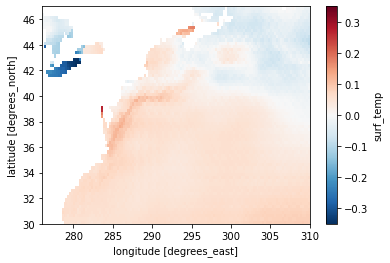

In [133]:
(ssp5_stemp_base - ssp1_stemp_base).surf_temp.plot()

## Perform Averaging at Temperature Horizons

Ended up doing this individually because the interpolation was running into issues.

In [82]:
# Slicing SSP1
ssp1_05C_stemp = ssp1_stemp.sel(time = slice("2048-01-01", "2052-12-31"), longitude = slice(360-84, 360-50), latitude = slice(47, 30)).mean(dim = "time")
ssp1_05C_btemp = ssp1_btemp.sel(time = slice("2048-01-01", "2052-12-31"), longitude = slice(360-84, 360-50), latitude = slice(47, 30)).mean(dim = "time")

In [78]:
# Slicing SSP5
ssp5_05C_stemp = ssp5_stemp.sel(time = slice("2034-01-01", "2038-12-31"), longitude = slice(360-84, 360-50), latitude = slice(47, 30)).mean(dim = "time")
ssp5_1C_stemp = ssp5_stemp.sel(time = slice("2041-01-01", "2045-12-31"), longitude = slice(360-84, 360-50), latitude = slice(47, 30)).mean(dim = "time")
ssp5_2C_stemp = ssp5_stemp.sel(time = slice("2064-01-01", "2068-12-31"), longitude = slice(360-84, 360-50), latitude = slice(47, 30)).mean(dim = "time")
ssp5_3C_stemp = ssp5_stemp.sel(time = slice("2077-01-01", "2081-12-31"), longitude = slice(360-84, 360-50), latitude = slice(47, 30)).mean(dim = "time")
ssp5_4C_stemp = ssp5_stemp.sel(time = slice("2095-01-01", "2099-12-31"), longitude = slice(360-84, 360-50), latitude = slice(47, 30)).mean(dim = "time")

# Bottom temp
ssp5_05C_btemp = ssp5_btemp.sel(time = slice("2034-01-01", "2038-12-31"), longitude = slice(360-84, 360-50), latitude = slice(47, 30)).mean(dim = "time")
ssp5_1C_btemp = ssp5_btemp.sel(time = slice("2041-01-01", "2045-12-31"), longitude = slice(360-84, 360-50), latitude = slice(47, 30)).mean(dim = "time")
ssp5_2C_btemp = ssp5_btemp.sel(time = slice("2064-01-01", "2068-12-31"), longitude = slice(360-84, 360-50), latitude = slice(47, 30)).mean(dim = "time")
ssp5_3C_btemp = ssp5_btemp.sel(time = slice("2077-01-01", "2081-12-31"), longitude = slice(360-84, 360-50), latitude = slice(47, 30)).mean(dim = "time")
ssp5_4C_btemp = ssp5_btemp.sel(time = slice("2095-01-01", "2099-12-31"), longitude = slice(360-84, 360-50), latitude = slice(47, 30)).mean(dim = "time")


### Map SSP1 & SSP5 at 0.5C

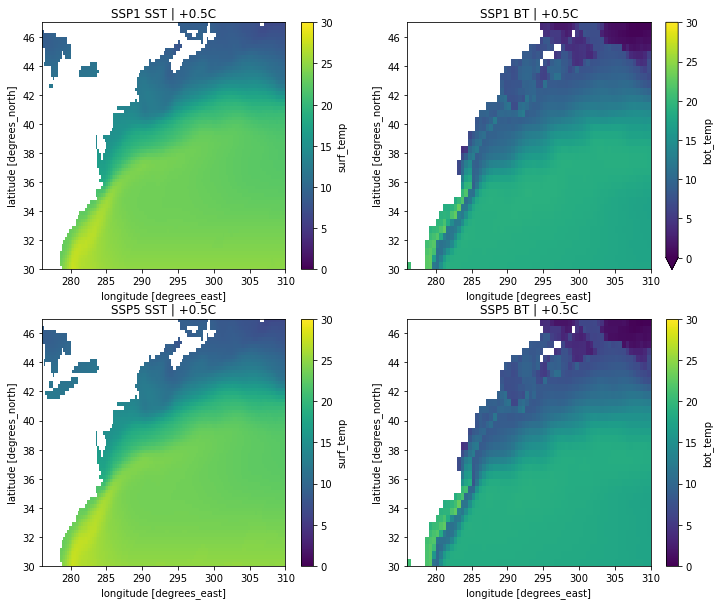

In [141]:
# Set your chosen color map limits
vmin = 0  # Minimum value for color mapping
vmax = 30  # Maximum value for color mapping

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot the first subplot
ssp1_05C_stemp.surf_temp.plot(ax=axes[0, 0], cmap = "viridis", vmin=vmin, vmax=vmax)
axes[0, 0].set_title("SSP1 SST | +0.5C")

# Plot the second subplot
ssp1_05C_btemp.bot_temp.plot(ax=axes[0, 1], cmap = "viridis", vmin=vmin, vmax=vmax)
axes[0, 1].set_title("SSP1 BT | +0.5C")

# Plot the first subplot
ssp5_05C_stemp.surf_temp.plot(ax=axes[1, 0], cmap = "viridis", vmin=vmin, vmax=vmax)
axes[1, 0].set_title("SSP5 SST | +0.5C")

# Plot the second subplot
ssp5_05C_btemp.bot_temp.plot(ax=axes[1, 1], cmap = "viridis", vmin=vmin, vmax=vmax)
axes[1, 1].set_title("SSP5 BT | +0.5C")

plt.show()

## Plotting SSP1 vs. SSP5 at 0.5C

These should in theory be very similar. But very different geographic patterns could create the same means so it might not be the case.

### Comparing the Differences from Baseline Across Scenarios

Each of the four panels represent the difference in one scenario's surface or bottom temperature from its conditions during the baseline period of 2010-2019.

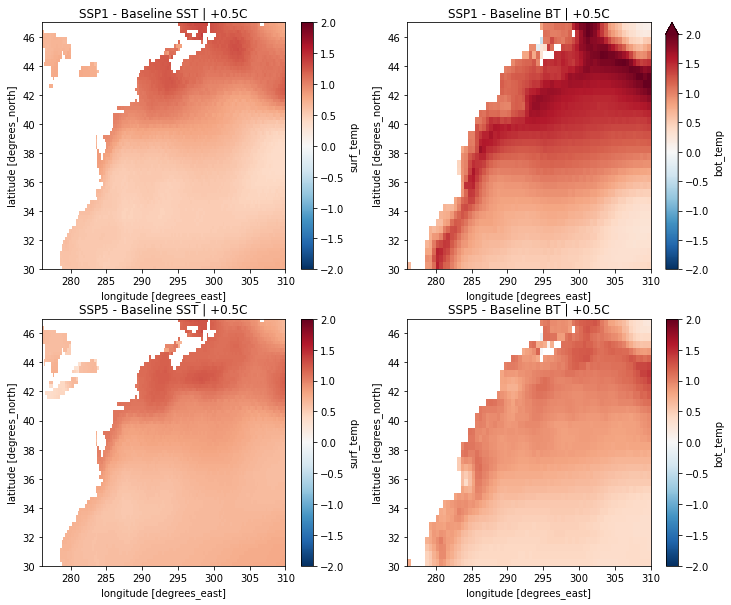

In [142]:
# Color limits
vmin = -2
vmax = 2

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot the first subplot
(ssp1_05C_stemp-ssp1_stemp_base).surf_temp.plot(ax=axes[0, 0], cmap = "RdBu_r", vmin=vmin, vmax=vmax)
axes[0, 0].set_title("SSP1 - Baseline SST | +0.5C")

# Plot the second subplot
(ssp1_05C_btemp-ssp1_btemp_base).bot_temp.plot(ax=axes[0, 1], cmap = "RdBu_r", vmin=vmin, vmax=vmax)
axes[0, 1].set_title("SSP1 - Baseline BT | +0.5C")

# Plot the third subplot
(ssp5_05C_stemp-ssp5_stemp_base).surf_temp.plot(ax=axes[1, 0], cmap = "RdBu_r", vmin=vmin, vmax=vmax)
axes[1, 0].set_title("SSP5 - Baseline SST | +0.5C")

# Plot the fourth subplot
(ssp5_05C_btemp-ssp5_btemp_base).bot_temp.plot(ax=axes[1, 1], cmap = "RdBu_r", vmin=vmin, vmax=vmax)
axes[1, 1].set_title("SSP5 - Baseline BT | +0.5C")

plt.show()

## Geographic Patterns across Scenarios

### How much hotter is SSP5 than SSP1 at the +0.5C Threshold?

At the timesteps where both scenarios are on-average +0.5C above baseline:

SSP5 Appears to have a warmer Mid-Atlantic than SSP1 at the half a degree threshold for SST. However it seems to be running 1-2C Colder at bottom during this same time.


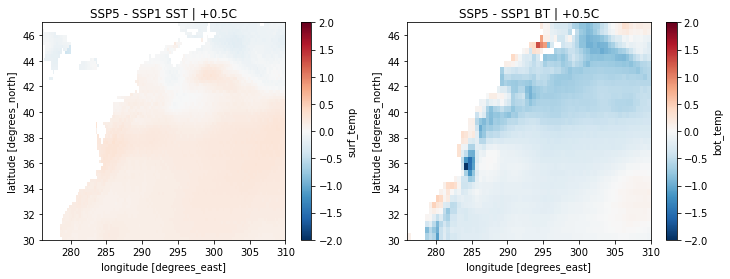

In [131]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

(ssp5_05C_stemp - ssp1_05C_stemp).surf_temp.plot(ax=axes[0], cmap = "RdBu_r", vmin=vmin, vmax=vmax)
axes[0].set_title("SSP5 - SSP1 SST | +0.5C")

(ssp5_05C_btemp - ssp1_05C_btemp).bot_temp.plot(ax=axes[1], cmap = "RdBu_r", vmin=vmin, vmax=vmax)
axes[1].set_title("SSP5 - SSP1 BT | +0.5C")

plt.show()

## Is there a geographic difference in how much warmer than baseline, each scenario is?
### (SSP5 - Base) - (SSP1 - BASE)

The amount that SSP5 at 0.5C is warmer than its baseline is highest in the Mid-Atlantic and Georges Bank.

The amount that SSP1 is above the baseline period is larger in the Northeast Channel Area and the Northern Scotian Shelf.


#### **There is apparent geographic difference between these two ensembles when both are 0.5C above Basline**

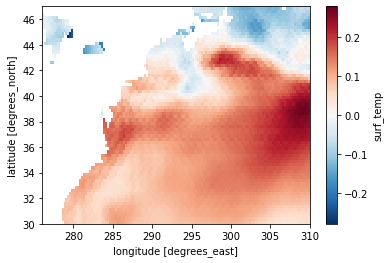

In [104]:
((ssp5_05C_stemp - ssp5_stemp_base) -  (ssp1_05C_stemp - ssp1_stemp_base)).surf_temp.plot()

# Saving

We want from this notebook:
 1. Baseline Averages for:
   - SSP1 SST   
   - SSP1 BT   
   - SSP5 SST   
   - SSP5 BT   
 2. Conditions when the region is +0.5C for:
   - SSP1 SST
   - SSP1 BT
   - SSP5 SST
   - SSP5 BT
 3. Conditions at +1C for:
   - SSP5 SST
   - SSP5 BT
 4. Conditions at +2C for:
   - SSP5 SST
   - SSP5 BT
 5. Conditions at +3C for:
   - SSP5 SST
   - SSP5 BT
 6. Conditions at +4C for:
   - SSP5 SST
   - SSP5 BT


In [ ]:
# Saving These Things


# Save Location


#----- Saving Baselines


#----- Saving 0.5C  ------


#----- Saving 1C  ------



#----- Saving 2C  ------



#----- Saving 3C  ------




#----- Saving 4C  ------